In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [6]:
def create_greedy_policy(Q, nA):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    def policy_fn(observation):
        A = np.zeros(nA, dtype=float)
        A[Q[observation].argmax()] = 1
        return A
    return policy_fn

In [8]:
# quick check
Q = {0: np.array([1,2,3]), 1: np.array([2,5,1])}
nA = 3
pi = create_greedy_policy(Q,nA)
pi(1)

array([0., 1., 0.])

In [20]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    CW = defaultdict(float)
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q, env.action_space.n)
    
    for ep in range(num_episodes):
        obs = env.reset()
        steps = []
        for t in range(100):
            action = np.random.choice(env.action_space.n, p=behavior_policy(obs))
            new_obs, reward, stop, _ = env.step(action)
            steps.append((obs, action, reward))
            obs = new_obs
            if stop:
                break

        # we will use importance sampling tailored to the fact that target policy is deterministic
        W = 1
        G = 0
        for obs, act, r in reversed(steps):
            G = discount_factor * G + r
            CW[(obs, act)] += W
            Q[obs][act] += W*(G - Q[obs][act])/CW[(obs, act)]
            target_action = Q[obs].argmax()
            if target_action != act:
                break
            b_prob = behavior_policy(obs)[act]
            W *= 1 / b_prob
        #  i though line below is necessary, butit isn't - Q still names the same object..
        # target_policy = create_greedy_policy(Q, env.action_space.n)

        
    return Q, target_policy

In [21]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

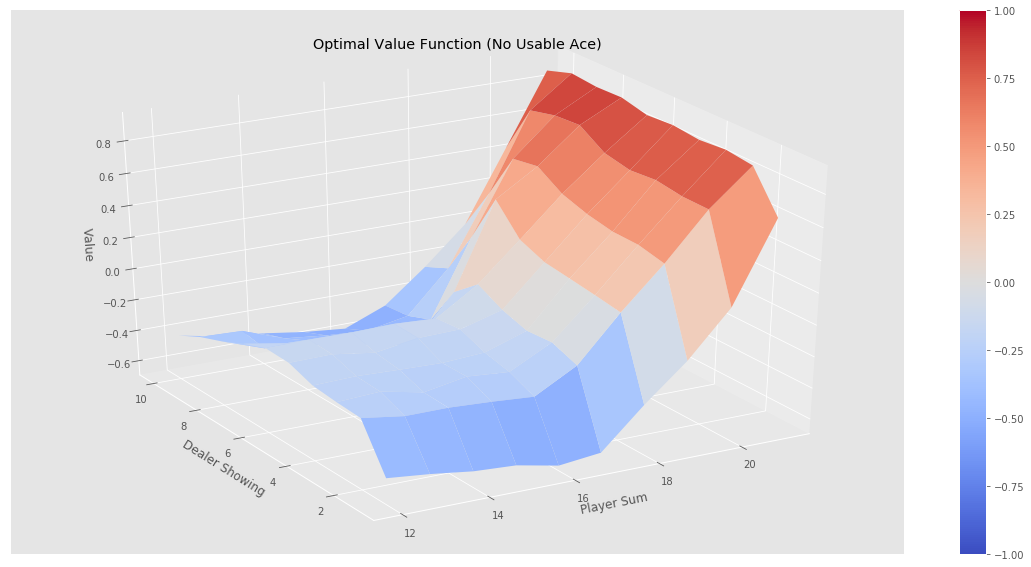

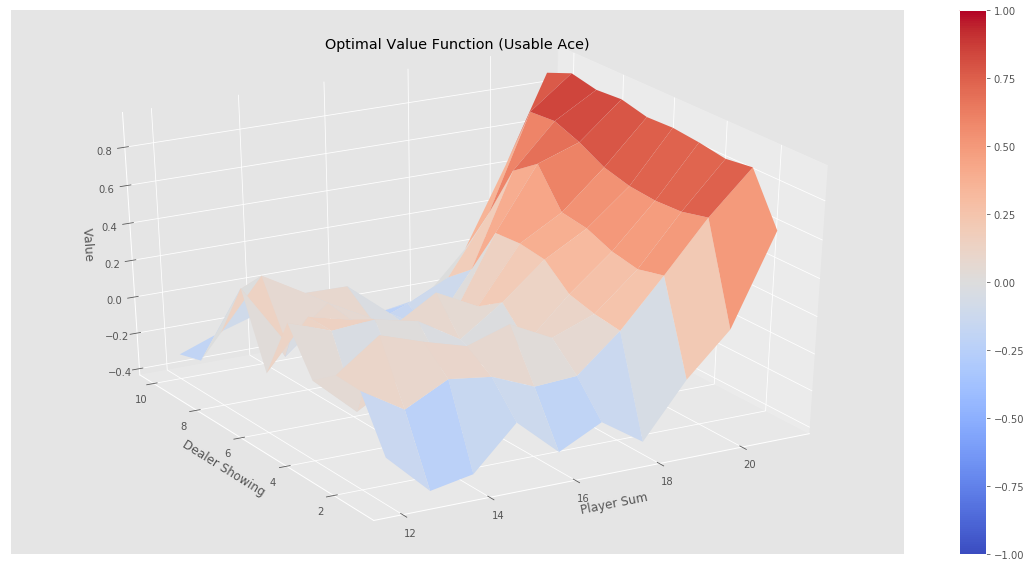

In [22]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")